# **Business Understanding**

### **Latar Belakang**
Tim inventory meminta untuk membuat prediksi jumlah penjualan (quantity) dari total keseluruhan product Kalbe pada tahun 2022.

### **Tujuan**
Tujuan dari project ini adalah untuk mengetahui perkiraan quantity product yang terjual sehingga tim inventory dapat membuat stock persediaan harian yang cukup. Prediksi yang dilakukan harus harian.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
!pip install pmdarima
import pmdarima as pm

In [3]:
transaction = pd.read_csv('/content/drive/MyDrive/PBI Kalbe Nutritionals/Case Study - Transaction.csv', sep = ';')

In [4]:
transaction

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4
...,...,...,...,...,...,...,...,...
5015,TR54423,243,31/12/2022,P10,15000,5,75000,3
5016,TR5604,271,31/12/2022,P2,3200,4,12800,9
5017,TR81224,52,31/12/2022,P7,9400,6,56400,9
5018,TR85016,18,31/12/2022,P8,16000,3,48000,13


In [5]:
transaction['Date'] = pd.to_datetime(transaction['Date'], format = '%d/%m/%Y')
data = transaction.groupby(['Date']).agg({'Qty':'sum'}).reset_index()

In [6]:
data

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,30
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


In [7]:
data.duplicated().sum()

0

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Qty     365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


Berdasarkan output dari `data.info()` dan `data.duplicated()`, dapat disimpulkan bahwa tidak ada nilai yang hilang atau pengamatan yang terduplikasi.

In [9]:
# Menjadikan kolom Date sebagai indeks
data.set_index('Date', inplace=True)

## **Exploratory Data Analysis**

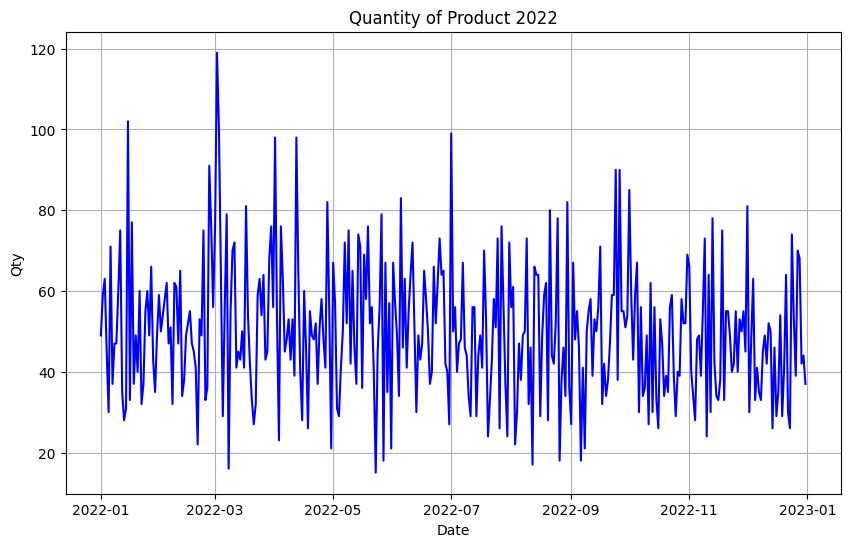

In [10]:
# Memvisualisasikan data
plt.figure(figsize=(10, 6))
plt.plot(data, color='b', linestyle='-')
plt.title('Quantity of Product 2022')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.grid(True)
plt.show()


In [11]:
# Menampilkan statistik deskriptif dari data
print("Statistik deskriptif dari data:")
round(data.describe(),2)

Statistik deskriptif dari data:


,Qty
count,365.00
mean,50.13
std,16.70
min,15.00
25%,38.00
50%,49.00
75%,59.00
max,119.00


In [12]:
# Menampilkan jumlah penjualan per bulan
print("Jumlah penjualan per bulan:")
pd.DataFrame(data['Qty'].resample('M').sum())

Jumlah penjualan per bulan:


,Qty
Date,
2022-01-31,1560
2022-02-28,1441
2022-03-31,1753
2022-04-30,1554
2022-05-31,1589
2022-06-30,1592
2022-07-31,1532
2022-08-31,1492
2022-09-30,1499


In [130]:
# Menampilkan total penjualan
print("Total penjualan selama setahun:")
data['Qty'].sum()

Total penjualan selama setahun:


18296

In [131]:
# Menampilkan hari dengan penjualan tertinggi
print("Hari dengan penjualan tertinggi:")
data[data['Qty'] == data['Qty'].max()]

Hari dengan penjualan tertinggi:


,Qty
Date,
2022-03-02,119


In [132]:
# Menampilkan hari dengan penjualan terendah
print("Hari dengan penjualan terendah:")
data[data['Qty'] == data['Qty'].min()]

Hari dengan penjualan terendah:


,Qty
Date,
2022-05-23,15


## **Uji Stasioneritas Data**

In [16]:
from statsmodels.tsa.stattools import adfuller

# Fungsi untuk menguji stasioneritas
def test_stationarity(timeseries):
    # Uji stasioneritas
    result = adfuller(timeseries)

    # Menampilkan output
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Uji stasioneritas pada data Qty
test_stationarity(data)


ADF Statistic: -19.448086319449082
p-value: 0.0
Critical Values:
   1%: -3.4484434475193777
   5%: -2.869513170510808
   10%: -2.571017574266393


**Uji Augmented Dickey-Fuller** (ADF) adalah alat statistik yang digunakan untuk menguji apakah suatu deret waktu stasioner atau tidak. Berdasarkan output tersebut, karena p-value lebih kecil dari 0.05, maka dapat disimpulkan bahwa data bersifat stasioner.

## **Data Split**

In [17]:
# Pisahkan data menjadi data pelatihan (80%) dan data uji (20%)
train_size = int(len(data) * 0.8)
train_data, test_data = data['Qty'][:train_size], data['Qty'][train_size:]

In [31]:
# Melihat ukuran pemisahan data
train_data.shape,test_data.shape

((292,), (73,))

## **Plot ACF dan PACF**

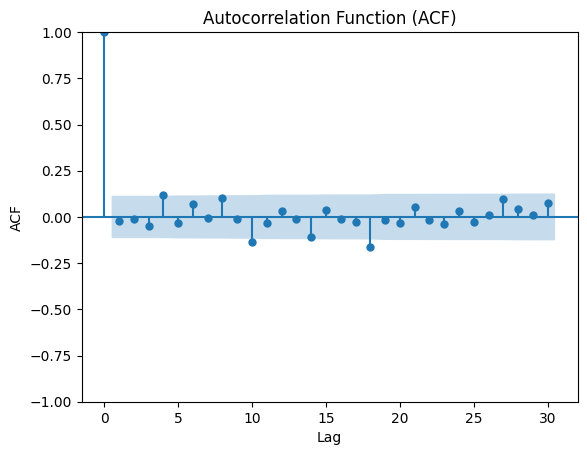

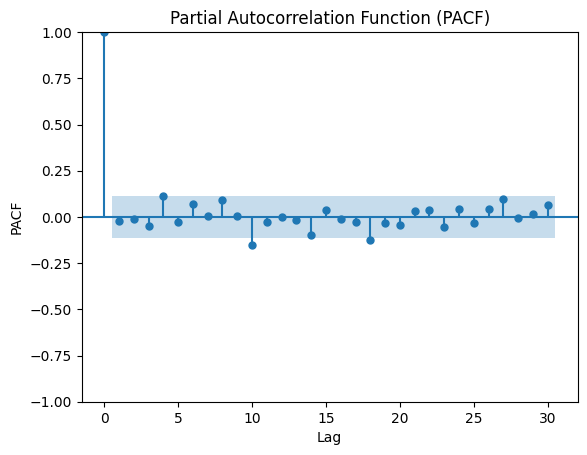

In [79]:
# Membuat plot ACF
plot_acf(train_data, lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# Membuat plot PACF
plot_pacf(train_data, lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()


**Plot ACF** (Autocorrelation Function) menunjukkan seberapa kuat hubungan antara angka dalam deret waktu pada waktu sebelumnya, sementara **plot PACF** (Partial Autocorrelation Function) menunjukkan hubungan langsung antara angka pada waktu tertentu setelah mengabaikan pengaruh angka di waktu sebelumnya. Berdasarkan plot acf dan pacf dari data training di atas, dapat disimpulkan bahwa nilai **orde p dan q adalah 0**

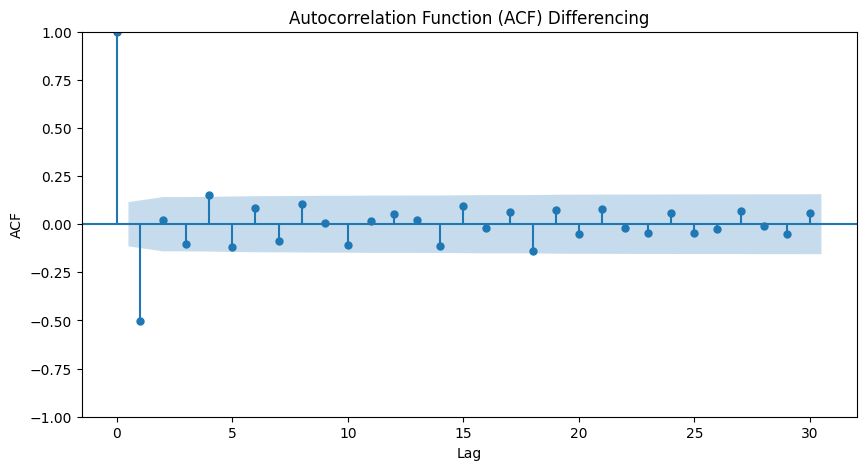

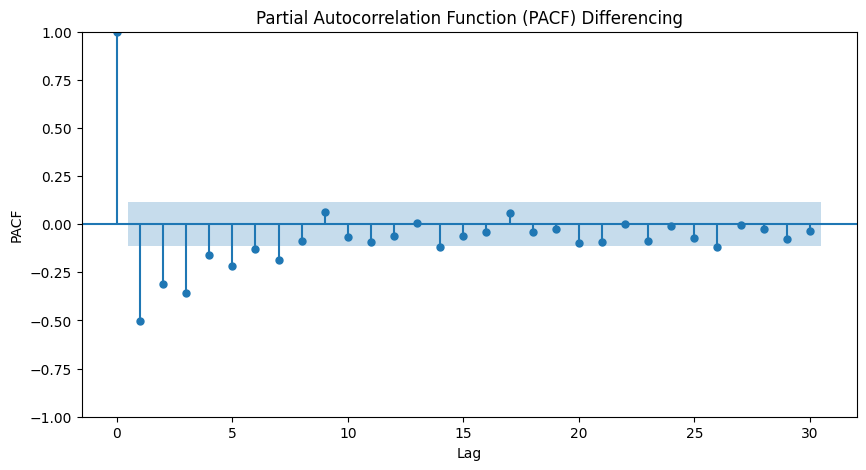

In [134]:
# Menghitung differencing
diff_data = train_data.diff().dropna()

# Membuat plot ACF (differencing)
plt.figure(figsize=(10, 5))
plot_acf(diff_data, lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) Differencing')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# Membuat plot PACF (differencing)
plt.figure(figsize=(10, 5))
plot_pacf(diff_data, lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) Differencing')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

Berdasarkan plot acf dan pacf dari data training yang sudah di differencing, dapat disimpulkan bahwa nilai orde **q = 1** dan **p = 1**.

## **Auto Arima**

In [81]:
# Membangun model ARIMA otomatis dengan data latih
auto = pm.auto_arima(train_data, seasonal=True, stepwise=True, trace=True)
auto

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2500.829, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2494.528, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2496.416, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2496.413, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3158.558, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2498.422, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.960 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

**AutoARIMA** adalah sebuah metode dalam analisis deret waktu yang memungkinkan pencarian otomatis untuk parameter terbaik dalam model ARIMA. Berdasarkan output dari autoARIMA menggunakan data latih, maka dapat disimpulkan bahwa kombinasi orde terbaik sama dengan hasil plot acf dan pacf yaitu [0,0,0]

## **Pemodelan Arima**

In [82]:
# Melatih model ARIMA (parameter autoARIMA)
model_1 = ARIMA(train_data, order=(0, 0, 0))
model_fit = model_1.fit()

# Membuat peramalan untuk data uji
forecast_1 = model_fit.forecast(steps=len(test_data))

# Menampilkan hasil peramalan
print("Forecasted Values:")
print(forecast_1)

mape_1 = mean_absolute_percentage_error(test_data,forecast_1)

Forecasted Values:
2022-10-20    51.020543
2022-10-21    51.020543
2022-10-22    51.020543
2022-10-23    51.020543
2022-10-24    51.020543
                ...    
2022-12-27    51.020543
2022-12-28    51.020543
2022-12-29    51.020543
2022-12-30    51.020543
2022-12-31    51.020543
Freq: D, Name: predicted_mean, Length: 73, dtype: float64


0.30814861122898074

In [83]:
# Melatih model ARIMA (parameter differencing)
model_2 = ARIMA(train_data, order=(1, 1, 1))
model_fit = model_2.fit()

# Membuat peramalan untuk data uji
forecast_2 = model_fit.forecast(steps=len(test_data))

# Menampilkan hasil peramalan
print("Forecasted Values:")
print(forecast_2)

mape_2 = mean_absolute_percentage_error(test_data,forecast_2)

Forecasted Values:
2022-10-20    50.064785
2022-10-21    49.710800
2022-10-22    49.718600
2022-10-23    49.718428
2022-10-24    49.718432
                ...    
2022-12-27    49.718432
2022-12-28    49.718432
2022-12-29    49.718432
2022-12-30    49.718432
2022-12-31    49.718432
Freq: D, Name: predicted_mean, Length: 73, dtype: float64


0.2933697079293775

# **Grid Search**

In [70]:
import itertools
import warnings
import statsmodels.api as sm

# Mendefinisikan rentang parameter p, d, dan q sesuai keinginan
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)
pdq = list(itertools.product(p, d, q))

# Mengabaikan peringatan konvergensi
warnings.filterwarnings("ignore")

# Menyimpan hasil
best_aic = float("inf")
best_order = None
best_model = None

# Iterasi melalui kombinasi parameter
for param in pdq:
    try:
        model = sm.tsa.ARIMA(train_data, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = param
            best_model = results
    except Exception as e:
        continue

print(f'Best ARIMA{best_order} model AIC: {best_aic}')

Best ARIMA(2, 1, 3) model AIC: 2489.2071952804217


**Grid search** adalah teknik yang digunakan untuk menemukan parameter terbaik untuk model. Dalam konteks ARIMA, grid search digunakan untuk mencari kombinasi parameter p, d, dan q yang memberikan kinerja terbaik dalam memodelkan dan meramalkan data time series. Setiap kombinasi tersebut kemudian dievaluasi berdasarkan kriteria tertentu, seperti *Akaike Information Criterion* (AIC)

In [84]:
# Melatih model ARIMA
model_3 = ARIMA(train_data, order= best_order)
model_fit = model_3.fit()

# Membuat peramalan untuk data uji
forecast_3 = model_fit.forecast(steps=len(test_data))

# Menampilkan hasil peramalan
print("Forecasted Values:")
print(forecast_3)

mape_3 = mean_absolute_percentage_error(test_data,forecast_3)

Forecasted Values:
2022-10-20    56.795245
2022-10-21    45.907157
2022-10-22    55.228750
2022-10-23    48.105387
2022-10-24    52.606065
                ...    
2022-12-27    51.724571
2022-12-28    50.513478
2022-12-29    51.416996
2022-12-30    50.873217
2022-12-31    51.036033
Freq: D, Name: predicted_mean, Length: 73, dtype: float64


0.307324648793066

## **Manual Hyperparameter Tuning**

In [29]:
# Melatih model ARIMA
model_4 = ARIMA(train_data, order=(56, 0, 56))
model_fit = model_4.fit()

# Membuat peramalan untuk data uji
forecast_4 = model_fit.forecast(steps=len(test_data))

# Menampilkan hasil peramalan
print("Forecasted Values:")
print(forecast_4)

mape_4 = mean_absolute_percentage_error(test_data,forecast_4)

Forecasted Values:
2022-10-20    56.121881
2022-10-21    47.502079
2022-10-22    50.894909
2022-10-23    66.928086
2022-10-24    40.114069
                ...    
2022-12-27    67.445422
2022-12-28    57.165662
2022-12-29    65.624891
2022-12-30    44.407657
2022-12-31    61.096263
Freq: D, Name: predicted_mean, Length: 73, dtype: float64


0.30991444760630543

## **Perbandingan Model**

In [106]:
print("MAPE model 1 : ", mape_1)
print("MAPE model 2 : ", mape_2)
print("MAPE model 3 : ", mape_3)
print("MAPE model 4 : ", mape_4)

MAPE model 1 :  0.30814861122898074
MAPE model 2 :  0.2933697079293775
MAPE model 3 :  0.307324648793066
MAPE model 4 :  0.30991444760630543


**Mean Absolute Percentage Error** (MAPE) merupakan ukuran kesalahan relatif. MAPE menyatakan persentase kesalahan hasil peramalan. MAPE menyatakan rata-rata kesalahan mutlak selama periode tertentu yang kemudian dikalikan 100% sehingga didapatkan hasil berupa persentase. Kesalahan dalam bentuk persentase memiliki keunggulan tidak terikat dengan satuan, sehingga sering digunakan untuk membandingkan kinerja perkiraan antara set data.

Berdasarkan nilai MAPE dari keenam model, dapat disimpulkan bahwa model 2 adalah model terbaik karena memiliki nilai **MAPE terkecil yaitu 29.3%**. Namun jika mempertimbangkan hasil ramalan, maka model 3 dan 4 juga merupakan kandidat yang bagus. Untuk melihat perbandingannya dapat dilihat pada plot berikut.

## **Visualisasi Hasil Training**

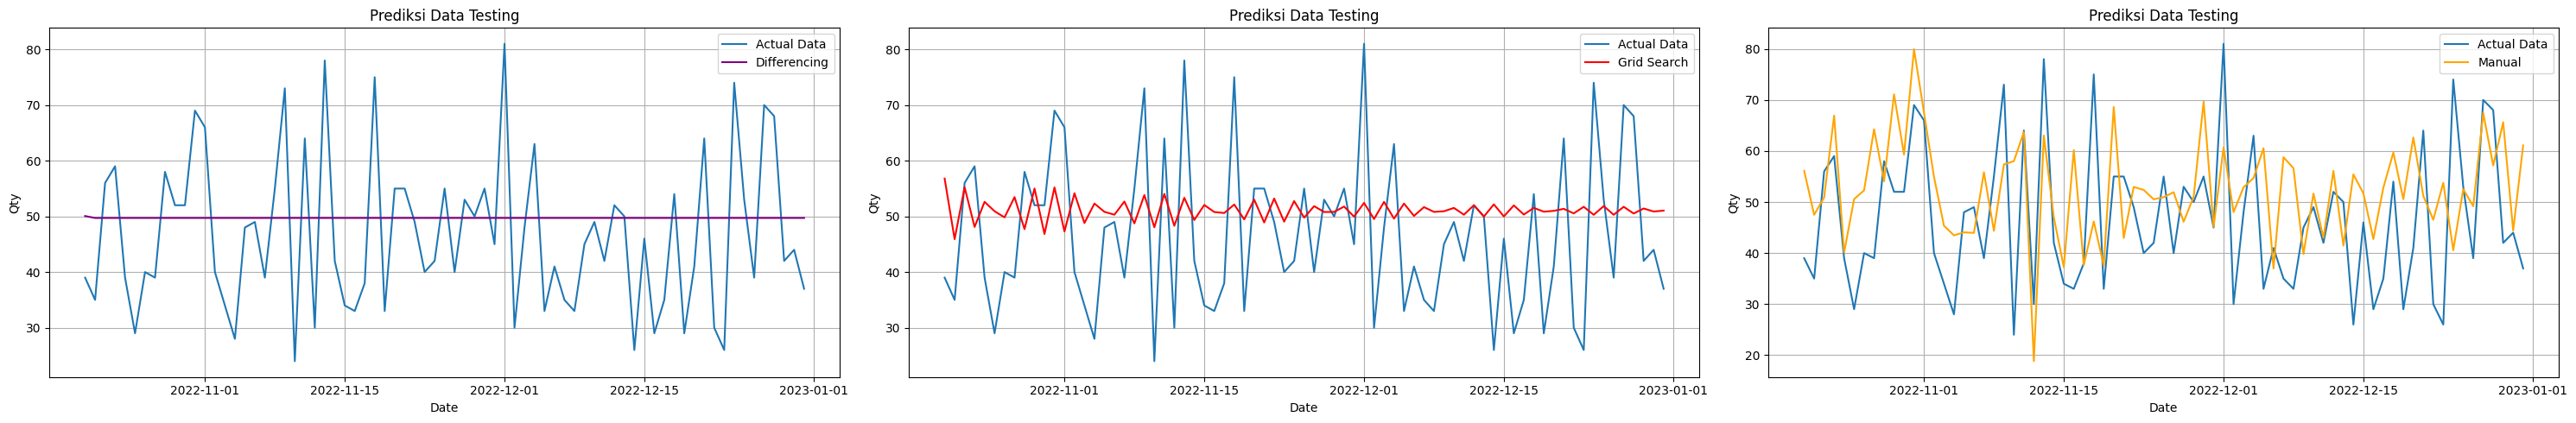

In [136]:
plt.figure(figsize=(30, 5))

# Plot pertama: Differencing
plt.subplot(1, 3, 1)
plt.plot(test_data.index, test_data.values, label='Actual Data')
plt.plot(test_data.index, forecast_2, color='purple', label='Differencing')
plt.title('Prediksi Data Testing')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.grid(True)

# Plot kedua: Grid Search
plt.subplot(1, 3, 2)
plt.plot(test_data.index, test_data.values, label='Actual Data')
plt.plot(test_data.index, forecast_3, color='red', label='Grid Search')
plt.title('Prediksi Data Testing')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.grid(True)

# Plot ketiga: Manual
plt.subplot(1, 3, 3)
plt.plot(test_data.index, test_data.values, label='Actual Data')
plt.plot(test_data.index, forecast_4, color='orange', label='Manual')
plt.title('Prediksi Data Testing')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Meskipun memiliki nilai MAPE terendah, hasil prediksi pada grafik model differencing cenderung stagnan dibandingkan dengan dua plot lainnya.

## **Peramalan Untuk Data Baru**

In [114]:
# Prediksi data baru menggunakan model ARIMA
diff_model = ARIMA(data, order=(1, 1, 1))
model_fit = diff_model.fit()

# Membuat peramalan untuk data baru
new_forecast_2 = model_fit.forecast(steps=10)

# Menampilkan hasil peramalan
print("New Forecasted Values:")
print(new_forecast_2)

New Forecasted Values:
2023-01-01    47.784769
2023-01-02    47.386589
2023-01-03    47.401290
2023-01-04    47.400747
2023-01-05    47.400767
2023-01-06    47.400767
2023-01-07    47.400767
2023-01-08    47.400767
2023-01-09    47.400767
2023-01-10    47.400767
Freq: D, Name: predicted_mean, dtype: float64


In [115]:
# Prediksi data baru menggunakan model ARIMA
grid_model = ARIMA(data, order=(2, 1, 3))
model_fit = grid_model.fit()

# Membuat peramalan untuk data baru
new_forecast_3 = model_fit.forecast(steps=10)

# Menampilkan hasil peramalan
print("New Forecasted Values:")
print(new_forecast_3)

New Forecasted Values:
2023-01-01    50.170967
2023-01-02    43.692851
2023-01-03    51.912557
2023-01-04    42.658151
2023-01-05    52.183554
2023-01-06    43.145639
2023-01-07    51.002263
2023-01-08    44.903738
2023-01-09    48.825650
2023-01-10    47.313160
Freq: D, Name: predicted_mean, dtype: float64


In [116]:
# Prediksi data baru menggunakan model ARIMA
manual_model = ARIMA(data, order=(56, 0, 56))
model_fit = manual_model.fit()

# Membuat peramalan untuk data baru
new_forecast_4 = model_fit.forecast(steps=10)

# Menampilkan hasil peramalan
print("New Forecasted Values:")
print(new_forecast_4)

New Forecasted Values:
2023-01-01    57.398451
2023-01-02    53.513915
2023-01-03    53.627731
2023-01-04    22.975124
2023-01-05    68.837732
2023-01-06    39.547371
2023-01-07    65.108130
2023-01-08    53.141830
2023-01-09    58.606779
2023-01-10    53.265347
Freq: D, Name: predicted_mean, dtype: float64


In [124]:
# Memilih tanggal untuk awalan dari visualisasi prediksi data baru
selected_data = test_data['2022-11-30':'2023-01-01']

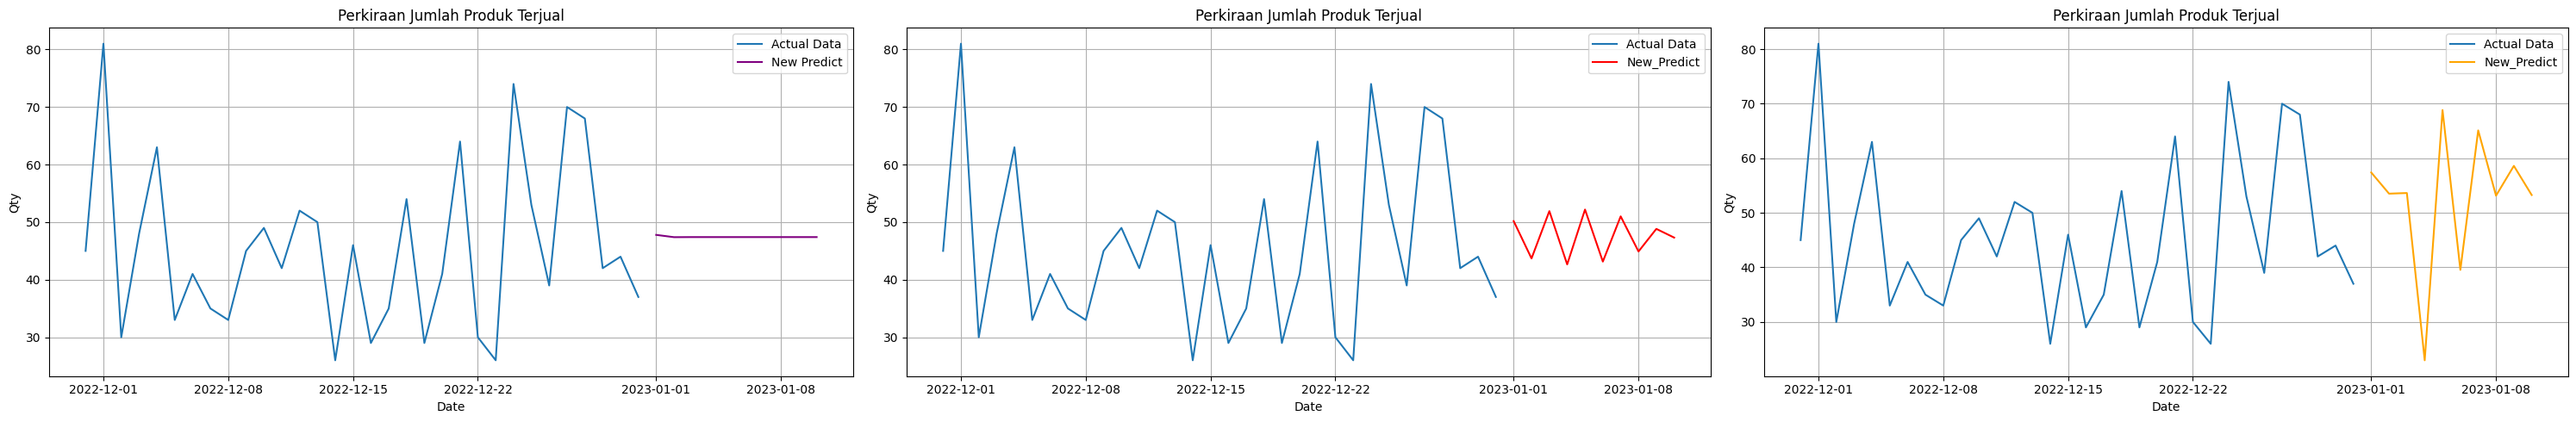

In [135]:
# Visualisasi prediksi data baru
plt.figure(figsize=(30, 5))

# Plot pertama: Differencing
plt.subplot(1, 3, 1)
plt.plot(selected_data.index, selected_data.values, label='Actual Data')
plt.plot(new_forecast_2, color='purple', label='New Predict')
plt.title('Perkiraan Jumlah Produk Terjual')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.grid(True)

# Plot kedua: Grid Search
plt.subplot(1, 3, 2)
plt.plot(selected_data.index, selected_data.values, label='Actual Data')
plt.plot(new_forecast_3, color='red', label='New_Predict')
plt.title('Perkiraan Jumlah Produk Terjual')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.grid(True)

# Plot ketiga: Manual
plt.subplot(1, 3, 3)
plt.plot(selected_data.index, selected_data.values, label='Actual Data')
plt.plot(new_forecast_4, color='orange', label='New_Predict')
plt.title('Perkiraan Jumlah Produk Terjual')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [129]:
# Perkiraan rata-rata product yang akan terjual di awal tahun 2023
print(round(new_forecast_2.mean()))
print(round(new_forecast_3.mean()))
print(round(new_forecast_4.mean()))

47
48
53


# **Kesimpulan**
## Berdasarkan hasil peramalan menggunakan metode ARIMA dengan berbagai pendekatan yang berbeda, maka diperkirakan pada awal tahun 2023 akan ada sekitar 47 - 53 produk yang terjual.